In [1]:
import os,glob
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import time


from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback,EarlyStopping
from tensorflow.keras import Sequential
from sklearn import metrics
#for ResNet50
from tensorflow.keras.applications import ResNet50V2, MobileNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import classification_report
#for Xception
from tf_explain.core.activations import ExtractActivations
from tensorflow.keras.applications.xception import decode_predictions

In [2]:
#get file path of training data 
file_path='data'
#get classes from folder names for benign and malignant
name_class=os.listdir(file_path)
name_class

['without_mask', 'with_mask']

In [3]:
#get and store filepaths of all images
filepaths=list(glob.glob(file_path+'/**/*.*'))
#store the labels according to folder
labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
labels

['without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask',
 'without_mask

In [4]:
#store data as series
filepath= pd.Series(filepaths, name='Filepath').astype(str)
labels=pd.Series(labels, name='Label')
data=pd.concat([filepath, labels],axis=1)
data=data.sample(frac=1).reset_index(drop=True)
data.head(5)

,Filepath,Label
0,data\with_mask\with_mask_2892.jpg,with_mask
1,data\with_mask\with_mask_1848.jpg,with_mask
2,data\without_mask\without_mask_2205.jpg,without_mask
3,data\without_mask\without_mask_2741.jpg,without_mask
4,data\with_mask\with_mask_1119.jpg,with_mask


(array([0, 1]), [Text(0, 0, 'without_mask'), Text(1, 0, 'with_mask')])

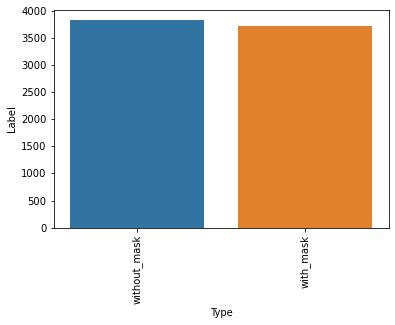

In [5]:
#check count of each class
counts=data.Label.value_counts()
sb.barplot(x=counts.index, y=counts)
plt.xlabel('Type')
plt.xticks(rotation=90)

In [6]:
#train test split for validation with 0.25 
train, test= train_test_split(data, test_size=0.20, stratify=labels, random_state=53)

In [7]:
#apply preprocessing: normalizing, reshaping, augmentation
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

test_datagen = ImageDataGenerator(rescale=1. /255)

In [9]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=256,
    shuffle=True,
    seed=42
)
valid_gen = train_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=256,
    shuffle=False,
    seed=42
)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=256,
    shuffle=False
)

Found 6042 validated image filenames belonging to 2 classes.
Found 1511 validated image filenames belonging to 2 classes.
Found 1511 validated image filenames belonging to 2 classes.


In [10]:
pretrained_model= ResNet50V2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet'
)
pretrained_model.traindable= False

94668760/94668760 [==============================] - 3s 0us/step


In [13]:
model = Sequential([
    pretrained_model,
    Flatten(name="flatten"),
    Dense(1024, activation='relu', name='hidden_layer'),
    Dropout(0.5),
    Dense(2, activation='sigmoid', name='output')
])

In [14]:
model.compile(
    optimizer='adam',  #can test different ones
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [15]:
#early stopping function if no improvement for more than 2 epochs
my_callbacks = [EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=2,
                              mode='max')]


In [16]:
start = time.time()
history= model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=30
)

Epoch 1/30
10/24 [===========>..................] - ETA: 32:48 - loss: 3.6508 - accuracy: 0.8266

C:\Users\irfan\anaconda3\lib\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


24/24 [==============================] - 3499s 143s/step - loss: 1.6040 - accuracy: 0.9106 - val_loss: 218.9649 - val_accuracy: 0.5414
Epoch 2/30
24/24 [==============================] - 3470s 144s/step - loss: 0.0400 - accuracy: 0.9902 - val_loss: 5.5673 - val_accuracy: 0.7584
Epoch 3/30
24/24 [==============================] - 3499s 146s/step - loss: 0.0140 - accuracy: 0.9957 - val_loss: 1.6461 - val_accuracy: 0.9199
Epoch 4/30
24/24 [==============================] - 3346s 139s/step - loss: 0.0118 - accuracy: 0.9964 - val_loss: 1.6482 - val_accuracy: 0.8769
Epoch 5/30
24/24 [==============================] - 3321s 139s/step - loss: 0.0099 - accuracy: 0.9975 - val_loss: 2.8509 - val_accuracy: 0.9113
Epoch 6/30
24/24 [==============================] - 3259s 136s/step - loss: 0.0116 - accuracy: 0.9957 - val_loss: 0.4532 - val_accuracy: 0.9682
Epoch 7/30
24/24 [==============================] - 3238s 135s/step - loss: 0.0163 - accuracy: 0.9947 - val_loss: 2.6576 - val_accuracy: 0.9279
E

In [17]:
model.save("model_detector.h5")
time.time()-start

97025.84205293655

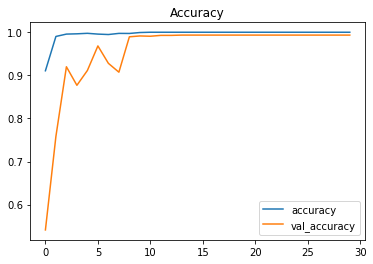

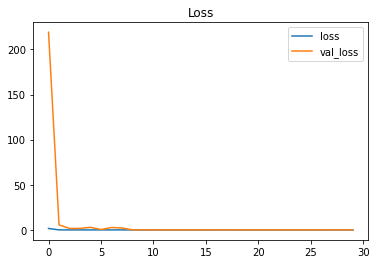

In [18]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()


In [19]:
results= model.evaluate(test_gen, verbose=0)
print("\tTest Loss: {:5f}".format(results[0]))
print("test Accuracy: {:2f}%".format(results[1]*100))

	Test Loss: 0.057551
test Accuracy: 99.338186%


In [20]:
pred= model.predict(test_gen)
pred=np.argmax(pred,axis=1)

labels=(train_gen.class_indices)
labels=dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]


6/6 [==============================] - 82s 13s/step


In [21]:
y_test=list(test.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

   with_mask       0.99      1.00      0.99       763
without_mask       1.00      0.99      0.99       748

    accuracy                           0.99      1511
   macro avg       0.99      0.99      0.99      1511
weighted avg       0.99      0.99      0.99      1511



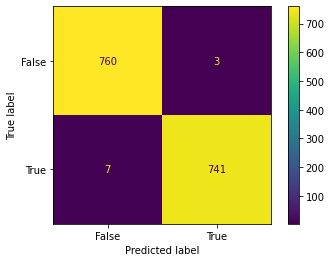

In [22]:
#confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()